### Import mujoco and numpy

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [184]:
class CentroidModel(object):
    def __init__(self, dt=0.1) -> None:
        self.dt = dt
        self.m  = 1.0
        self.J  = np.diag([1.0,1.0,1.0])
        self.Jinv = np.linalg.inv(self.J)
        self.g = np.array([0,0,-9.81])

    def dfdt(self, x, u, c):
        Rt1 = x[:9].reshape((3,3))
        pt1 = x[9:12]
        wt1 = x[12:15]
        vt1 = x[15:]
        F1   = u
        tau = ca.cross(pt1-x, F)
        Rdot = Rt1 @ ca.skew(wt1)
        pdot = Rt1 @ vt1
        wdot = self.Jinv@(tau - ca.cross(wt1, self.J@wt1))
        vdot = F/self.m + self.g
        return ca.vertcat(Rdot[:], pdot, wdot, vdot)

    def f(self, x, u):
        # euler step
        return x + self._dt * self.dfdt(x, u)

hopper_model = HopperDynamics()
tf = 2
N = int(tf/hopper_model._dt)
def loss(x, u):
    J = 0.0
    for t in range(N):
        # xd = np.maximum(2.0, 2*np.sin(hopper_model._dt*t*2*np.pi)+2.0)
        xd=1.0
        # vd = 2*np.cos(hopper_model._dt*t*2*np.pi*2)*2*np.pi*2
        J = J + (x[0,t]-xd)**2 #+ 10*(x[1,t]-vd)**2
    J = J + (x[0,-1]-xd)**2
    return J/float(N)
# ca.sumsqr(u) + 
def phi(x, u):
    return x[0]-u[1]

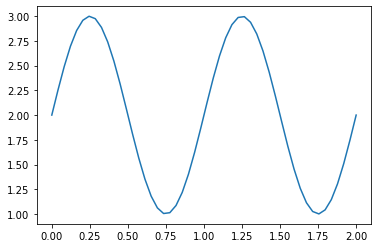

In [185]:
t = np.linspace(0,2)
plt.plot(t, np.sin(t * 2 * np.pi)+2)

In [196]:
opti = ca.Opti()

x  = opti.variable(2, N+1) # Decision variables for state trajetcory
u  = opti.variable(2, N)
p  = opti.parameter(2, 1)  # initial cond Parameter (not optimized over)
pf = opti.parameter(2,1)
opti.minimize(loss(x,u))

for k in range(N):
  opti.subject_to(x[:,k+1]==hopper_model.f(x[:,k],u[:,k]))
  # opti.subject_to(hopper_model.manip_eq(x[:,k+1],x[:,k],u[:,k])==0)
  opti.subject_to(phi(x[:,k], u[:,k])>=0)
  opti.subject_to(phi(x[:,k], u[:,k])*u[0,k]<=0.1)
  opti.subject_to(u[0,k]>=0)
  opti.subject_to(opti.bounded(-2,u[1,k],2))
  # opti.subject_to(u[1,k]<=0)

# opti.subject_to(opti.bounded(-1,u[1,:],1))
opti.subject_to(x[:,0]==p) #np.array([2.,0.]))
# opti.subject_to(u>=0)
# opti.subject_to(x[:,-1]==pf) #np.array([10.,0.]))


In [197]:
p_opts = {"expand": True}
s_opts = {"max_iter": 500, "acceptable_tol": 1e-3, "acceptable_obj_change_tol":1e-7, "tol":1e-8, "slack_bound_push": 0.1, "slack_bound_frac":0.5}
opti.solver('ipopt', p_opts, s_opts)

# And choose a concrete value for p
opti.set_value(p, [2.,0.])
# opti.set_value(pf, [1.1 ,0.])
sol = opti.solve()

This is Ipopt version 3.14.5, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      122
Number of nonzeros in inequality constraint Jacobian.:      140
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables............................:       82
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:       40
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0500000e+00 2.00e+00 5.78e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [198]:
(x,u) = (sol.value(x).T, sol.value(u).T)

In [199]:
con1 = []
for xi, ui in zip(x,u):
    con1.append(phi(xi, ui)*ui[0])

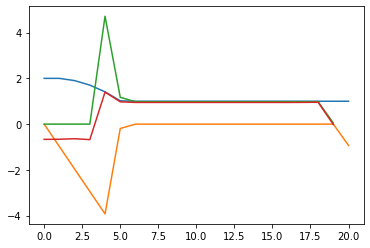

In [200]:
# plt.plot(opti.debug.value(x).T)
# plt.plot(opti.debug.value(u).T)

plt.plot(x)
# plt.plot(t/hopper_model._dt, 2*np.sin(t * 2*2 * np.pi)+2)
plt.plot(u)

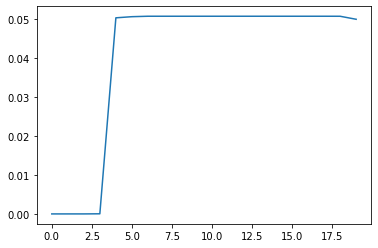

In [191]:
plt.plot(con1)